In [1]:
import astropy.io.fits as pf
import pylab as mplot
%pylab inline
import healpy as hp
from astropy import units as u
from astropy.coordinates import SkyCoord
from pylab import cm
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)

Populating the interactive namespace from numpy and matplotlib


In [ ]:
planck_data = pf.open('HFI_PCCS_SZ-union_R2.08.fits')[1].data
sz_map = hp.read_map('COM_CompMap_Compton-SZMap-milca-ymaps_2048_R2.00.fits', nest=False)

NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


/Users/bjain/anaconda3/lib/python3.7/site-packages/healpy/fitsfunc.py:371: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


In [ ]:
z = planck_data['redshift']
snr = planck_data['snr']
mass = planck_data['MSZ']
lon = planck_data['glon']
lat = planck_data['glat']
ra = planck_data['ra']
dec = planck_data['dec']

# find the 40 highest SNR clusters with 0<z<0.2
N = 10
id_snr = np.argsort(snr[(z>0)*(z<0.2)])[-1*N:][::-1]
snr_sel = snr[(z>0)*(z<0.2)][id_snr]

Z_sel = z[(z>0)*(z<0.2)][id_snr]
SNR_sel = snr[(z>0)*(z<0.2)][id_snr]
MASS_sel = mass[(z>0)*(z<0.2)][id_snr]
LON_sel, LAT_sel = lon[(z>0)*(z<0.2)][id_snr], lat[(z>0)*(z<0.2)][id_snr]
RA_sel, DEC_sel = ra[(z>0)*(z<0.2)][id_snr], dec[(z>0)*(z<0.2)][id_snr]

In [ ]:
nside = 2048
pix = np.arange(hp.nside2npix(nside))
theta_y, phi_y = hp.pix2ang(nside, pix)
lon_y = phi_y/np.pi*180
lat_y = 90.-(theta_y/np.pi*180)

In [ ]:
# first cluster has SZ mass M, assume SZ mass scales with M500, assume know R500 for first cluster is 18 arcmin
def M500_to_R500m(mass, z, cosmo):
    rho_m_z = cosmo.Om(z)*cosmo.critical_density(z)
    mass_units = mass*u.Msun
    R500m = ((mass_units/(500.*4.*np.pi*rho_m_z/3.))**(1./3.)).to('Mpc')
    return R500m.value

R500_MSZ = M500_to_R500m(MASS_sel[0]*10**14, Z_sel[0], cosmo)
Factor = R500_MSZ*(1+Z_sel[0])/(18./60/180*np.pi)/cosmo.comoving_distance(Z_sel[0]).value
print(Factor)

1.7599036881505379


R500 in arcmin 17.999999999999996


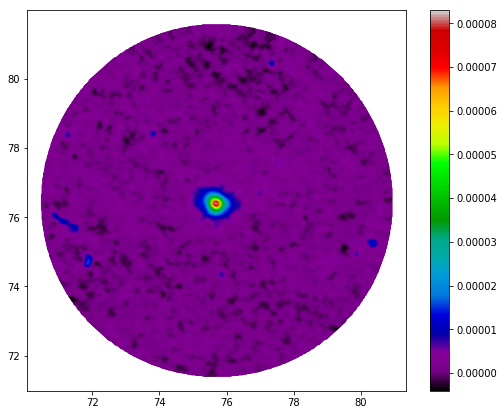

7
13
22
37
42
45
47
50
68
65
64
93
91
92
88
120
121
126
142
117
132
141
172
154
170
177
180
187
186
202
206
200
211
232
247
240
241
234
279
251
281
289
282
299
292
321
290
353
337
372
334
343
400
363
369
344
382
388
402
413
390
450
435
469
396
410
494
455
476
437
451
473
487
526
503
538
521
502
577
531
567
532
565
553
606
569
573
612
635
654
603
664
637
706
661
663
683
703
694
707
7
14
24
28
42
40
54
61
46
76
68
70
99
100
109
134
118
114
127
130
139
173
171
172
180
198
183
200
219
205
229
215
198
206
239
217
275
266
277
236
291
314
302
317
345
323
319
326
354
307
333
376
377
342
404
328
406
384
391
447
405
450
403
442
426
467
467
478
504
511
501
519
515
494
474
542
547
547
532
505
530
555
553
567
590
532
631
605
570
629
616
656
668
622
659
642
661
636
634
740
8
13
19
29
32
30
41
44
68
74
73
80
97
100
95
88
126
156
142
124
140
157
170
167
166
178
213
212
189
185
224
209
234
228
235
245
278
270
242
291
327
290
271
299
318
290
304
322
339
364
344
371
375
354
397
351
408
383
388
404
403
39

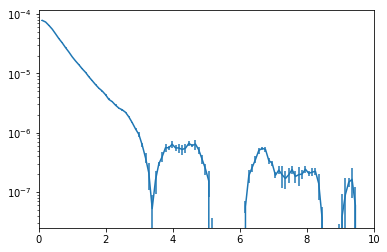

R500 in arcmin 15.410601608753057


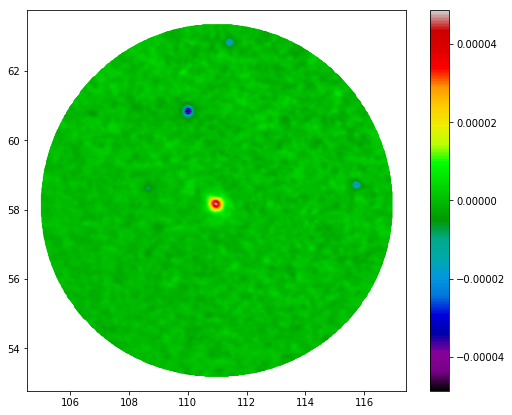

3
12
9
20
21
27
35
42
38
41
49
63
61
71
82
77
84
97
99
88
100
111
120
111
126
126
149
138
130
170
140
169
177
153
159
161
195
190
182
201
190
197
238
226
203
242
220
246
262
260
258
241
231
271
279
295
279
285
289
292
299
286
297
334
306
363
343
322
350
362
353
348
356
389
389
364
407
409
399
425
366
386
437
410
435
434
423
421
444
459


In [ ]:
for i in range(10):

    R500 = (1+Z_sel[i])*M500_to_R500m(MASS_sel[i]*10**14/Factor**3, Z_sel[i], cosmo)/cosmo.comoving_distance(Z_sel[i]).value /np.pi*180.*60
    print('R500 in arcmin', R500)
    
    c1 = SkyCoord(LON_sel[i]*u.degree, LAT_sel[i]*u.degree, frame='icrs')
    c2 = SkyCoord(lon_y*u.degree, lat_y*u.degree, frame='icrs')
    sep = c1.separation(c2)
    mask_cluster = (sep.degree<5)

    mplot.figure(figsize=(8.5,7))
    mplot.scatter(lon_y[mask_cluster], (90. - lat_y[mask_cluster]), c=sz_map[mask_cluster], cmap='nipy_spectral')
    mplot.colorbar()
    mplot.show()


    ids = np.arange(len(sz_map[mask_cluster]))
    Npix = len(sz_map[mask_cluster])
    bg_mask = (sep.value[mask_cluster]>3)

    bin_edge = np.linspace(0.05, 10.0, num=101)
    bin_min = bin_edge[:-1]
    bin_max = bin_edge[1:]
    
    Y_boot = []
    Y_boot_err = []

    for i in range(100):
        ids_new = np.random.choice(ids, size=Npix, replace=True)

        c2_new = SkyCoord(lon_y[mask_cluster][ids_new]*u.degree, lat_y[mask_cluster][ids_new]*u.degree, frame='icrs')
        sep_new = c1.separation(c2_new)

        bg_mask_new = bg_mask[ids_new]
        bg = np.median(sz_map[mask_cluster][bg_mask_new])

        Y = []
        for j in range(100):
            R_over_R500 = np.array(sep_new.degree)/R500
            mask = (R_over_R500 >= bin_min[j]/60)*(R_over_R500 < bin_max[j]/60)
            Y.append(np.mean(sz_map[mask_cluster][ids_new][mask]))

        Y = np.array(Y)
        Y_boot.append(Y)

    Y_boot = np.array(Y_boot)

    Y_err = np.std(Y_boot, axis=0)
    Y_mean = np.mean(Y_boot, axis=0)

    DD = (bin_min+bin_max)/2

    mplot.errorbar(DD, Y_mean-bg, yerr=Y_err)
    mplot.yscale('log')
    mplot.xlim(0,10)
    mplot.show()
    
    cov_boot = np.cov(Y_boot.T)

    np.savez('Planck_cluster_bootstrap_'+str(i)+'.npz', ra=RA_sel[i], dec=DEC_sel[i], lon=LON_sel[i], 
             lat=LAT_sel[i], z=Z_sel[i], mass=MASS_sel[i], snr=SNR_sel[i], R_over_R500=(bin_min+bin_max)/2, 
             mean_y=Y_mean, bg=bg, cov=cov_boot)
    
    
 

In [8]:
print(Y)

[           nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan 4.86140671e-05            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan 4.67621430e-05            nan            nan
            nan            nan            nan            nan
 4.77920657e-05         